# Gyro Neural Network – Orientation Classification

This project demonstrates **orientation classification** (Pitch, Roll, Yaw) using a simple feedforward neural network in TensorFlow/Keras.  
It uses gyroscope sensor data stored in CSV files and trains a model to classify the orientation into one of three classes.

---

## Features
- Loads CSV datasets for pitch, roll, and yaw.
- Combines and preprocesses the data for training/testing.
- Builds and trains a lightweight neural network.
- Visualizes training accuracy and loss.
- Runs a sample inference.
- Saves the trained model for deployment.

---


In [2]:
# ----------------------
# 1. Imports
# ----------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical


## 2. Load Dataset
Place your CSV files (`Pitch.csv`, `Roll.csv`, `Yaw.csv`) inside a `data/` folder in the project root.


In [3]:
# Load datasets
pitch = pd.read_csv("data/Pitch.csv")
roll  = pd.read_csv("data/Roll.csv")
yaw   = pd.read_csv("data/Yaw.csv")

# Combine datasets
data = pd.concat([pitch, roll, yaw])

# Encode class labels
label = "Class"
classes = data[label].unique().tolist()
data[label] = data[label].map(classes.index)

print(f"Dataset loaded with {len(data)} samples.")
data.head()


Dataset loaded with 3000 samples.


,x,y,z,Class
0,-22.22,-15.27,-27.27,0
1,-43.27,-6.25,7.40,0
2,-6.32,1.45,-17.87,0
3,-1.01,6.50,-20.01,0
4,14.96,-0.08,-8.32,0


## 3. Train-Test Split
We will split the dataset into 70% training and 30% testing data.


In [4]:
def split_dataset(data, test_ratio=0.3):
    test_indices = np.random.rand(len(data)) < test_ratio
    return data[~test_indices], data[test_indices]

train, test = split_dataset(data)

X_train = np.array(train.drop(label, axis=1), dtype=float)
y_train = np.array(train[label], dtype=int)
X_test  = np.array(test.drop(label, axis=1), dtype=float)
y_test  = np.array(test[label], dtype=int)

print(f"{len(X_train)} training samples, {len(X_test)} testing samples.")


2047 training samples, 953 testing samples.


## 4. Build the Neural Network
We use a simple architecture with:
- Input layer: 3 neurons (gyro x, y, z)
- Hidden layers: 8 → 10 → 10 neurons
- Output layer: 3 neurons (Pitch, Roll, Yaw)


In [5]:
model = Sequential()
model.add(Dense(8, input_dim=3, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265 (1.04 KB)

 Trainable params: 265 (1.04 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train the Model
We train for 20 epochs with a batch size of 5 and validate on the test set.


In [8]:
history = model.fit(X_train, to_categorical(y_train),
                    epochs=20, batch_size=5,
                    validation_data=(X_test, to_categorical(y_test)),
                    verbose=0)

## 6. Visualize Training Results
We plot both **accuracy** and **loss** over epochs.


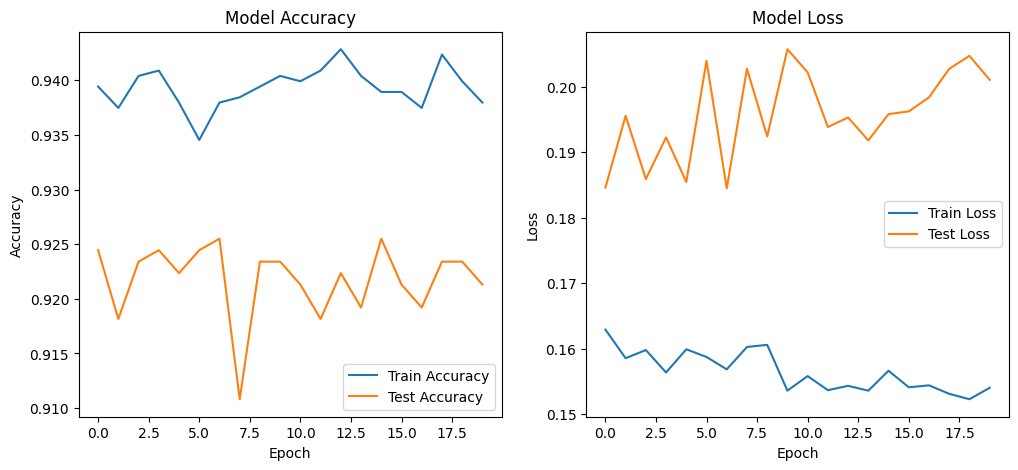

In [9]:
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


## 7. Sample Inference
We test the model with a dummy set of gyro readings to see the predicted orientation.


In [10]:
sample_input = np.array([[0.45, 0.12, 0.05]])  # Example gyro readings
pred_class = np.argmax(model.predict(sample_input), axis=-1)
class_names = ["Pitch", "Roll", "Yaw"]

print(f"Sample Input: {sample_input}")
print(f"Predicted Class: {class_names[pred_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Sample Input: [[0.45 0.12 0.05]]
Predicted Class: Pitch


## 8. Save the Model
We save the model as `orientation_model.tflite` for future use or deployment.


In [11]:
# Directly convert the in-memory Keras model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save TFLite model
with open("orientation_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model converted and saved as orientation_model.tflite")

INFO:tensorflow:Assets written to: C:\Users\harsh\AppData\Local\Temp\tmprti3v9b4\assets


INFO:tensorflow:Assets written to: C:\Users\harsh\AppData\Local\Temp\tmprti3v9b4\assets


Saved artifact at 'C:\Users\harsh\AppData\Local\Temp\tmprti3v9b4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1542156426256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1542156427408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1542156425488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1542156428176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1542156427024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1542156429136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1542156427792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1542156429328: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model converted and saved as orientation_model.tflite
